In [1]:
%%capture
# !pip3.12 install missingno
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_text
import seaborn as sns
import missingno as msno

# Análisis preliminar


In [2]:
# df_data_100 = pd.read_csv('train_data_100_lines.csv', encoding='ISO-8859-1')
# df_label = pd.read_csv('train_labels_50_lines.csv', encoding='ISO-8859-1')

In [3]:
# df_data_100.head()


In [4]:
# import pandas as pd

# # Revisar si las transacciones de un mismo cliente están consecutivas
# df_data_100['is_consecutive'] = df_data_100['ID'] == df_data_100['ID'].shift()

# # Verificar si hay filas donde el ID del cliente no es consecutivo
# non_consecutive = df_data_100[df_data_100['is_consecutive'] == False]

# if non_consecutive.empty:
#     print("Todas las transacciones de los clientes están colocadas consecutivamente.")
# else:
#     print(f"Hay {len(non_consecutive)} transacciones que no están consecutivas.")
#     print(non_consecutive[['ID']].drop_duplicates())  # Muestra los IDs no consecutivos


In [5]:
# df_data = pd.read_csv('train_data.csv', encoding='ISO-8859-1')


In [6]:
# df_data.shape[0]

### División en csv's


In [7]:

# # Definir el tamaño objetivo de 500,000 filas por CSV
# chunk_size = 500000

# # Inicializar variables
# current_chunk = []
# current_chunk_size = 0
# file_index = 1
# last_customer_id = None

# # Función para guardar el chunk actual en un CSV
# def save_chunk(chunk, file_index):
#     df_chunk = pd.DataFrame(chunk)
#     df_chunk.to_csv(f'train_data_part_{file_index}.csv', index=False)
#     print(f'Archivo train_data_part_{file_index}.csv guardado con {len(df_chunk)} filas.')

# # Iterar sobre el DataFrame
# for i, row in df_data.iterrows():
#     customer_id = row['ID']

#     # Si hemos alcanzado el tamaño máximo del chunk y el nuevo customer_id es diferente al último en el chunk
#     if current_chunk_size >= chunk_size and customer_id != last_customer_id:
#         save_chunk(current_chunk, file_index)  # Guardar el CSV actual
#         file_index += 1
#         current_chunk = []  # Reiniciar el chunk
#         current_chunk_size = 0

#     # Añadir la fila actual al chunk
#     current_chunk.append(row)
#     current_chunk_size += 1
#     last_customer_id = customer_id

# # Guardar el último chunk si no está vacío
# if current_chunk:
#     save_chunk(current_chunk, file_index)


In [8]:
# df_data_part_1 = pd.read_csv('train_data_part_1.csv', encoding='ISO-8859-1')

In [9]:
# pd.set_option('display.max_rows', None)

In [10]:
# percentage = df_data_part_1.isnull().mean() * 100
# columns_with_nulls = percentage[percentage > 0]
# print(columns_with_nulls)


# Preprocesado  


## Cargado de csv's


In [11]:
for i in range(1, 8):
    file_name = f'../data/train_data_part_{i}.csv'
    globals()[f'df_data_part_{i}'] = pd.read_csv(file_name, encoding='ISO-8859-1')
    print(f'Archivo {file_name} cargado en df_data_part_{i}')

Archivo ../data/train_data_part_1.csv cargado en df_data_part_1
Archivo ../data/train_data_part_2.csv cargado en df_data_part_2
Archivo ../data/train_data_part_3.csv cargado en df_data_part_3
Archivo ../data/train_data_part_4.csv cargado en df_data_part_4
Archivo ../data/train_data_part_5.csv cargado en df_data_part_5
Archivo ../data/train_data_part_6.csv cargado en df_data_part_6
Archivo ../data/train_data_part_7.csv cargado en df_data_part_7


### Comprobar columnas con valores nulos

In [12]:
def null_percentage(df, percentage):
    null_ratio = {}
    for col in df.columns:
        ratio = df[col].isna().sum() / len(df) * 100
        if ratio > percentage:
            null_ratio[col] = ratio
           
    return null_ratio

Me quedo solo con las columnas con menos de 80% de valores nulos

In [13]:
columns_with_high_nulls = []
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    null_columns = set(null_percentage(data_frame, 50).keys())
    
    # Si es el primer DataFrame, inicializar el conjunto con sus columnas
    if i == 1:
        columns_with_high_nulls = null_columns
    else:
        # Mantener solo las columnas que están en todos los DataFrames
        columns_with_high_nulls = columns_with_high_nulls.intersection(null_columns)

columns_with_high_nulls = list(columns_with_high_nulls)

print(f"Columnas con más del 50% de valores nulos en todos los CSVs: {columns_with_high_nulls}")

Columnas con más del 50% de valores nulos en todos los CSVs: ['Infraction_WLMI', 'Infraction_SBF', 'Infraction_ZTLC', 'Base_64022', 'Infraction_IRKE', 'Infraction_CLLY', 'Risk_5797', 'Infraction_HPS', 'Infraction_QGC', 'Infraction_HPLO', 'Infraction_ADWZ', 'Risk_4561', 'Infraction_MAN', 'Infraction_GWL', 'Base_8379', 'Infraction_MZI', 'Expenditure_KMW', 'Infraction_FUSM', 'Infraction_SVKR', 'Infraction_APIU', 'Infraction_ZVHJ', 'Infraction_NCB', 'Infraction_WWLN', 'Infraction_WEG', 'Infraction_EBA', 'Base_3958', 'Infraction_JVWF', 'Infraction_GEL', 'Base_8318', 'Infraction_ANHZ']


Eliminamos las columnas con más de 80% de valores nulos en todos los csv's

In [14]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame.drop(columns=columns_with_high_nulls, inplace=True)
    

### Comprobar si hay filas que tengan todas las columnas a null


In [15]:
# Verificar si hay filas completamente nulas
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    null_rows = data_frame[data_frame.isnull().all(axis=1)]
    if not null_rows.empty:
        print(f'Filas completamente nulas en df_data_part_{i}:')
        print(null_rows)
    else:
        print(f'No hay filas completamente nulas en df_data_part_{i}.')

No hay filas completamente nulas en df_data_part_1.
No hay filas completamente nulas en df_data_part_2.
No hay filas completamente nulas en df_data_part_3.
No hay filas completamente nulas en df_data_part_4.
No hay filas completamente nulas en df_data_part_5.
No hay filas completamente nulas en df_data_part_6.
No hay filas completamente nulas en df_data_part_7.


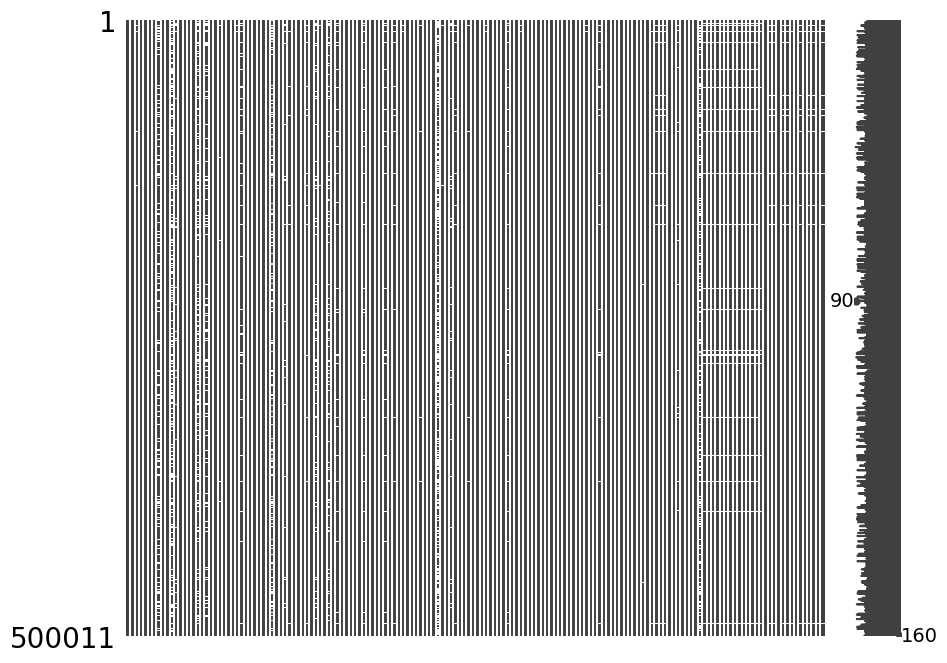

In [16]:
na_df = df_data_part_1
msno.matrix(na_df, figsize=(10, 8))
plt.show()

### Comprobar filas duplicadas

In [17]:
# Verificar si hay filas duplicadas en cada DataFrame
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    duplicate_rows = data_frame[data_frame.duplicated()]
    if not duplicate_rows.empty:
        print(f'Filas duplicadas en df_data_part_{i}:')
        print(duplicate_rows)
    else:
        print(f'No hay filas duplicadas en df_data_part_{i}.')

No hay filas duplicadas en df_data_part_1.
No hay filas duplicadas en df_data_part_2.
No hay filas duplicadas en df_data_part_3.
No hay filas duplicadas en df_data_part_4.
No hay filas duplicadas en df_data_part_5.
No hay filas duplicadas en df_data_part_6.
No hay filas duplicadas en df_data_part_7.


### Comprobar varianza 0

In [18]:
# Verificar si hay columnas con baja varianza
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    low_variance_cols = []
    for col in data_frame.columns:
        if data_frame[col].nunique() == 1:
            low_variance_cols.append(col)
    if low_variance_cols:
        print(f'Columnas con baja varianza en df_data_part_{i}: {low_variance_cols}')
    else:
        print(f'No hay columnas con baja varianza en df_data_part_{i}.')

No hay columnas con baja varianza en df_data_part_1.
No hay columnas con baja varianza en df_data_part_2.
No hay columnas con baja varianza en df_data_part_3.
No hay columnas con baja varianza en df_data_part_4.
No hay columnas con baja varianza en df_data_part_5.
No hay columnas con baja varianza en df_data_part_6.
No hay columnas con baja varianza en df_data_part_7.


# Análisis de tipo de variable

In [19]:
# Agrupar columnas por tipo de dato
data_types = {}
# No hace falta comprobar todos los df ya que tienen las mismas columnas
data_frame = df_data_part_1
for col in data_frame.columns:
    data_type = str(data_frame[col].dtype)
    if data_type not in data_types:
        data_types[data_type] = []
    data_types[data_type].append(col)

for data_type, columns in data_types.items():
    print(f'{data_type}: {columns}')

object: ['ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH', 'Base_67254', 'Infraction_TEN']
float64: ['Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863', 'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Risk_0322', 'Infraction_FMXQ', 'Infraction_GGO', 'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_6187', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Expenditure_YTR', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_BSU', 'Base_14808', 'Risk_8065', 'Infraction_ZYW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD', 'Infraction_PBC', 'Infraction_AQO', 'Base_0229', 'Base_69608', 'Base_91828', 'Base_6852', 'Expenditure_IDZ', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'I

## Variables categóricas


In [20]:
# Hacemos print de las columnas de tipo object, solo primeras filas
data_frame = df_data_part_1
print(data_frame.select_dtypes(include='object').head())

                                                  ID Expenditure_AHF  \
0  3333337004103300505242400473433643475477705348...      2017-03-05   
1  3333337004103300505242400473433643475477705348...      2017-04-20   
2  3333337004103300505242400473433643475477705348...      2017-05-11   
3  3333337004103300505242400473433643475477705348...      2017-06-29   
4  3333337004103300505242400473433643475477705348...      2017-08-03   

  Infraction_YFSG Infraction_DQLY Infraction_CLH    Base_67254 Infraction_TEN  
0              CO               O      very_high  moderate_low  extremely_low  
1              CO               O      very_high  moderate_low  extremely_low  
2              CO               O      very_high  moderate_low  extremely_low  
3              CO               O      very_high  moderate_low  extremely_low  
4              CO               O      very_high  moderate_low  extremely_low  


#### Transformación ID to_numeric

In [21]:
# Pasamos ID a número en todos los dataframes para facilitar su procesado
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['ID'] = pd.to_numeric(data_frame['ID'], errors='coerce')

#### Transformación Expenditure_AHF to_datetime

In [22]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Expenditure_AHF'] = pd.to_datetime(data_frame['Expenditure_AHF'], errors='coerce')
    data_frame['Expenditure_AHF_year'] = data_frame['Expenditure_AHF'].dt.year
    data_frame['Expenditure_AHF_month'] = data_frame['Expenditure_AHF'].dt.month
    data_frame['Expenditure_AHF_day'] = data_frame['Expenditure_AHF'].dt.day
    data_frame.drop(columns=['Expenditure_AHF'], inplace=True)


#### Transformación Infraction_YFSG encoding

In [23]:
# Ver los valores de la columna Infraction_YFSG en todos los DataFrames y hacer una intersección
unique_values = set()
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    unique_values_i = set(data_frame['Infraction_YFSG'].unique())
    if not unique_values:
        unique_values = unique_values_i
    else:
        unique_values = unique_values.intersection(unique_values_i)

print(unique_values)

{'CO', 'XL', 'XM', 'CL', 'CR', 'XZ'}


In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Infraction_YFSG_encoded'] = label_encoder.fit_transform(data_frame['Infraction_YFSG'])
    data_frame.drop(columns=['Infraction_YFSG'], inplace=True)


#### Transformación Infraction_DQLY

In [25]:
# Ver los valores de la columna Infraction_YFSG en todos los DataFrames y hacer una intersección
unique_values = set()
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    unique_values_i = set(data_frame['Infraction_DQLY'].unique())
    if not unique_values:
        unique_values = unique_values_i
    else:
        unique_values = unique_values.intersection(unique_values_i)

print(unique_values)

{'U', nan, 'O', '-1', 'R'}


In [26]:
# Análisis de porcentaje de NaNs en cada DataFrame en la columna Infraction_DQLY
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    print(f'Porcentaje de NaNs en df_data_part_{i}: {data_frame["Infraction_DQLY"].isna().mean() * 100:.2f}%')

Porcentaje de NaNs en df_data_part_1: 3.96%
Porcentaje de NaNs en df_data_part_2: 3.88%
Porcentaje de NaNs en df_data_part_3: 3.98%
Porcentaje de NaNs en df_data_part_4: 4.02%
Porcentaje de NaNs en df_data_part_5: 3.94%
Porcentaje de NaNs en df_data_part_6: 3.84%
Porcentaje de NaNs en df_data_part_7: 3.93%


Antes de codificarlo necesitamos tratar los NaN

In [27]:
# Como el porcentaje de NaNs es muy bajo (aprox. 4%), rellenamos los NaNs con el valor más común
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    most_common_value = data_frame['Infraction_DQLY'].mode()[0]
    data_frame['Infraction_DQLY'].fillna(most_common_value, inplace=True)



C:\Users\48726\AppData\Local\Temp\ipykernel_18256\2308713897.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame['Infraction_DQLY'].fillna(most_common_value, inplace=True)


##### Hacemos la codificación de la columna

In [28]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Infraction_DQLY_encoded'] = label_encoder.fit_transform(data_frame['Infraction_DQLY'])
    data_frame.drop(columns=['Infraction_DQLY'], inplace=True)


### Las siguientes columnas comparten etiquetas

In [29]:
ordinal_columns = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']

for col in ordinal_columns:
    print(f'{col}: {df_data_part_1[col].unique()}')

Infraction_CLH: ['very_high' 'moderate_low' 'moderate' 'high' nan 'moderate_high'
 'very_low' 'low']
Base_67254: ['moderate_low' 'low' 'moderate' 'high' 'very_high' 'extremely_high'
 'moderate_high' nan]
Infraction_TEN: ['extremely_low' 'very_high' 'moderate_high' 'moderate_low' 'low' nan
 'moderate' 'high']


In [30]:
frequency_map = {
    'extremely_low': 0,
    'very_low': 1,
    'moderate_low': 2,
    'low': 3,
    'moderate': 4,
    'high':5,
    'moderate_high': 6,
    'very_high': 7,
    'extremely_high': 8
}


for i in range(1, 8):
    for col in ordinal_columns:
        data_frame = globals()[f'df_data_part_{i}']
        data_frame[f'{col}_encoded'] = data_frame[col].map(frequency_map)
        data_frame.drop(columns=[col], inplace=True)

In [31]:
ordinal_columns = ['Infraction_CLH_encoded', 'Base_67254_encoded', 'Infraction_TEN_encoded']

for col in ordinal_columns:
    print(f'{col}: {df_data_part_1[col].unique()}')

Infraction_CLH_encoded: [ 7.  2.  4.  5. nan  6.  1.  3.]
Base_67254_encoded: [ 2.  3.  4.  5.  7.  8.  6. nan]
Infraction_TEN_encoded: [ 0.  7.  6.  2.  3. nan  4.  5.]


In [32]:
# Voy a ver cuántos valores NaN hay en cada columna de las ordinal_columns en la intersection de los DataFrames como porcentaje
for col in ordinal_columns:
    nan_count = 0
    total = 0
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        total += data_frame[col].shape[0]
        nan_count += data_frame[col].isna().sum()
    print(f'{col}: {nan_count/total*100:.2f}%')

Infraction_CLH_encoded: 3.92%
Base_67254_encoded: 0.04%
Infraction_TEN_encoded: 3.21%


Es un porcentaje muy bajo así que podemos rellenarlos sin problema. En este caso usaremos la moda

In [33]:
# Quiero saber el valor que más se repite en cada columna ordinal
for col in ordinal_columns:
    most_common_values = []
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        most_common_value = data_frame[col].mode()[0]
        most_common_values.append(most_common_value)
    print(f'{col}: {most_common_values}')
    

Infraction_CLH_encoded: [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
Base_67254_encoded: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Infraction_TEN_encoded: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [34]:
# Rellenar los valores NaN con el valor más común en cada columna ordinal.
for col in ordinal_columns:
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        most_common_value = data_frame[col].mode()[0]
        data_frame[col] = data_frame[col].fillna(most_common_value)


## Comprobación columnas duplicadas

In [35]:
# Ya hemos visto que las categóricas no están dulpicadas entre sí así que solo analizamos si las columnas numéricas están duplicadas
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    duplicate_columns = data_frame.columns[data_frame.columns.duplicated()]
    if not duplicate_columns.empty:
        print(f'Columnas duplicadas en df_data_part_{i}: {duplicate_columns}')
    else:
        print(f'No hay columnas duplicadas en df_data_part_{i}.')


No hay columnas duplicadas en df_data_part_1.
No hay columnas duplicadas en df_data_part_2.
No hay columnas duplicadas en df_data_part_3.
No hay columnas duplicadas en df_data_part_4.
No hay columnas duplicadas en df_data_part_5.
No hay columnas duplicadas en df_data_part_6.
No hay columnas duplicadas en df_data_part_7.


### Podemos hacer una matriz de correlación para comprobarlo

In [36]:
# # Vamos a hacer una matriz de correlación para ver si hay columnas altamente correlacionadas. Quiero hacer una matriz de correlación para cada DataFrame y luego compararlas para que seleccionar las columnas con correlación mayor a 0.9 y así eliminar una de ellas
# correlation_threshold = 0.9
# for i in range(1, 8):
#     data_frame = globals()[f'df_data_part_{i}']
#     corr = data_frame.corr()
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
#     plt.title(f'Correlation Matrix df_data_part_{i}')
#     plt.show()
#     # ahora hacemos una lista de las columnas con correlación mayor a 0.9
#     correlation_matrix = corr.abs()
#     upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#     if i == 1:
#         columns_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
#     else:
#         columns_current_matrix = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
#         #comprobar intersección de listas
#         columns_to_drop = list(set(columns_to_drop).intersection(columns_current_matrix))
# print(columns_to_drop)

In [37]:
# # Eliminamos las columnas que tengar correlación mayor a 0.9 o -0.9
# correlation_threshold = 0.9
# correlation_matrix = df_data_part_1.corr().abs()
# upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
# columns_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
# print(f'Columnas a eliminar: {columns_to_drop}')


## Comprobación NaNs

Vamos a analizar las filas para eliminar aquellas que tengan NaN en más del 30% de las columnas si estas componen una pequeña poción del dataframe y rellenar estos valores no tendría sentido ya que la fila perdería valor para el posterior estudio ya que sería completamente artificial

In [38]:
# Quiero saber cuántas filas tienen más del 30% de las columnas nulas en porcentaje sobre el total de todos los DataFrames
rows_to_drop = []
total_rows = 0
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    total_rows += data_frame.shape[0]
    null_percentage = data_frame.isnull().mean(axis=1) * 100
    rows_to_drop.extend(null_percentage[null_percentage > 30].index)
rows_to_drop = set(rows_to_drop)
print(f'Número de filas a eliminar: {len(rows_to_drop)/total_rows*100:.2f}%')


Número de filas a eliminar: 0.26%


In [39]:
# Eliminos las filas con más del 30% de valores nulos
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    # Como no me deja usar los valores de rows_to_drop como índices, lo hago de la siguiente manera
    data_frame.drop(data_frame.index.intersection(rows_to_drop), inplace=True)


Ahora vamos a hacer un análisis de las columnas que nos quedan

In [40]:
# Voy a ver cuántos valores NaN hay en cada columna en la intersection de los DataFrames.
columns_percentage = {}
for col in df_data_part_1.columns:
    nan_count = 0
    total_rows = 0
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        total_rows += data_frame.shape[0]
        nan_count += data_frame[col].isna().sum()
    if nan_count > 0:
        columns_percentage[col] = nan_count/total_rows * 100    
        print(f'{col}: {nan_count/total_rows * 100:.5f}%')

Payment_6804: 0.57285%
Base_80863: 0.00515%
Expenditure_JIG: 18.28497%
Infraction_SNZ: 0.00515%
Base_02683: 0.00515%
Infraction_ZWWJ: 29.85362%
Infraction_QJJF: 4.71919%
Infraction_EJZ: 0.00515%
Infraction_FMXQ: 21.68924%
Infraction_TLPJ: 12.72720%
Base_1165: 0.00009%
Base_6187: 0.37812%
Infraction_AYWV: 0.27658%
Payment_22507: 5.22159%
Infraction_PAS: 0.00515%
Expenditure_HMO: 18.28497%
Infraction_BSU: 3.13283%
Base_14808: 0.75777%
Infraction_HSSU: 1.70469%
Infraction_TBP: 10.71778%
Base_0580: 0.05267%
Infraction_PBC: 13.51881%
Base_0229: 0.00515%
Base_91828: 0.00515%
Base_6852: 0.00515%
Infraction_JYZB: 3.27808%
Base_22178: 0.00515%
Infraction_ZTYG: 1.46566%
Infraction_EYU: 0.17689%
Infraction_QKZN: 0.28817%
Risk_7095: 0.00003%
Infraction_JBR: 45.50540%
Base_66195: 0.05267%
Base_36516: 0.00515%
Infraction_RXQH: 4.71919%
Infraction_HFU: 1.12025%
Infraction_VTR: 0.28817%
Base_7331: 0.00515%
Infraction_XWX: 0.22756%
Risk_4553: 0.00074%
Infraction_VHU: 3.27808%
Risk_4247: 0.00003%
Infrac

Vamos a rellenar aquellas que tengan menos del 6% de NaNs y a eliminar los que tengan más de ese porcentaje , rellenar estos últimos no tendría sentido

In [41]:
# Eliminamos las columnas con más de 6% de valores nulos en la intersección de los DataFrames
for col in columns_percentage.keys():
    if columns_percentage[col] > 6:
        for i in range(1, 8):
            data_frame = globals()[f'df_data_part_{i}']
            data_frame.drop(columns=[col], inplace=True)    

In [42]:
# Vamos a rellenar los NaNs de las columnas restantes de la siguiente manera:
# Si la columna es categórica, rellena con la moda (no hace falta tenerlo en cuenta ahora ya que lo hemos hecho manualmnete anteriormente)
# Si la columna es numérica:
#           - con la media si la desviación estándar es menor a 1
#           - con la mediana si la desviación estándar es mayor a 1
#           - con la moda si la desviación estándar es 0

for col in df_data_part_1.columns:
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        if data_frame[col].isna().sum() != 0:
            mean = data_frame[col].mean()
            median = data_frame[col].median()
            mode = data_frame[col].mode()[0]
            std = data_frame[col].std()
            if std == 0:
                data_frame[col] = data_frame[col].fillna(mode)
            elif std < 1:
                data_frame[col] = data_frame[col].fillna(mean)
            else:
                data_frame[col] = data_frame[col].fillna(median)


## Tratar valores infinitos

In [43]:
# Imprimir los valores infinitos para tratarlos
from numpy import inf
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    infinite_values = data_frame[data_frame == np.inf].sum().sum()
    print(f'Valores infinitos en df_data_part_{i}: {infinite_values}')

Valores infinitos en df_data_part_1: 0.0
Valores infinitos en df_data_part_2: 0.0
Valores infinitos en df_data_part_3: 0.0
Valores infinitos en df_data_part_4: 0.0
Valores infinitos en df_data_part_5: 0.0
Valores infinitos en df_data_part_6: 0.0
Valores infinitos en df_data_part_7: 0.0


# Selección de características


In [44]:
df_labels_50 = pd.read_csv('../data/train_labels_50_lines.csv', encoding='ISO-8859-1')
df_labels_50.head()

,ID,label
0,3333337004103300505242400473433643475477705348...,0
1,3333412724050477534287115505554450368233003786...,0
2,3333755354307801420025735367852078550468735254...,0
3,3333545238615133608512002405572210535308150267...,0
4,3333333216773173414240337455254307444633113087...,1


### Filtro

Como la variable objetivo es binaria (0,1), probamos con ANOVA

In [ ]:
df_labels = pd.read_csv('train_labels.csv', encoding='ISO-8859-1')

In [ ]:
df_labels['ID'] = pd.to_numeric(df_labels['ID'], errors='coerce')

In [ ]:
# NO EJECUTAR más de una vez (pasan cosas raras con label)
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    globals()[f'df_merged_part_{i}'] = pd.merge(data_frame, df_labels, on='ID', how='left')


In [ ]:
for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']
    if 'label' not in data_frame.columns:
        print(f'La partición {i} no tiene la columna label.')
    else:
        print(f'La partición {i} tiene la columna label.')

La partición 1 tiene la columna label.
La partición 2 tiene la columna label.
La partición 3 tiene la columna label.
La partición 4 tiene la columna label.
La partición 5 tiene la columna label.
La partición 6 tiene la columna label.
La partición 7 tiene la columna label.


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif 

columns_data = df_data_part_1.columns
selected_features = set()

# Como el train data está dividido en 7 partes, vamos a hacer un loop para cargar cada parte y seleccionar las 5 características más importantes según ANOVA (f_classif)
for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']
        
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']
    
    selector = SelectKBest(score_func=f_classif, k=5)
    X_new = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    if i == 1:
        selected_features = set(columns_data[selected_indices])
    else:
        selected_features.intersection(set(data_frame.columns[selected_indices]))

print(f'Características seleccionadas {selected_features}')



Características seleccionadas {'Base_80863', 'Payment_6804', 'Base_85131', 'Infraction_QJJF', 'Base_69608'}


### Wrapper

In [49]:
# from sklearn.preprocessing import StandardScaler
# #scale data for each dataframe
# scaler = StandardScaler()
# for i in range(1, 8):
#     data_frame = globals()[f'df_data_part_{i}']
#     data_frame_scaled = pd.DataFrame(scaler.fit_transform(data_frame), columns=data_frame.columns)
#     globals()[f'df_data_part_{i}'] = data_frame_scaled

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

data_frame = df_data_part_1
data_frame_merged = pd.merge(data_frame, df_labels, on='ID', how='inner')
x = data_frame
y = data_frame_merged['label']
    
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
    
model = LogisticRegression(max_iter=3000, solver='saga') #soltion for big datasets
rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = rfe.fit_transform(x_scaled, y)
selected_indices = rfe.get_support(indices=True)
selected_features = data_frame_merged.columns[selected_indices]
S
print(f'Wybrane cechy w df_data_part_{i}: {selected_features}')


In [53]:
#perform wrapper method for feature selection for df1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

data_frame = df_data_part_1
data_frame_merged = pd.merge(data_frame, df_labels, on='ID', how='inner')
x = data_frame
y = data_frame_merged['label']
model = LogisticRegression(max_iter=8000)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(x, y)
selected_indices = rfe.get_support(indices=True)
selected_features = data_frame.columns[selected_indices]
print(f'Características seleccionadas en df_data_part_1: {selected_features}')

c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
# #perform wrapper method for feature selection
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# # Como el train data está dividido en 7 partes, vamos a hacer un loop para cargar cada parte y seleccionar las 5 características más importantes según RFE
# for i in range(1, 8):
#     data_frame = globals()[f'df_data_part_{i}']
#     data_frame_merged = pd.merge(data_frame, df_labels, on='ID', how='inner')
    
#     x = data_frame
#     y = data_frame_merged['label']
#     estimator = LogisticRegression()
#     selector = RFE(estimator, n_features_to_select=5)
#     X_new = selector.fit_transform(x, y)
#     selected_indices = selector.get_support(indices=True)
#     selected_features = data_frame.columns[selected_indices]

#     print(f'Características seleccionadas en df_data_part_{i}: {selected_features}')

c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

### Embebido

## Mejora de Hiperparámetros (optuna)

Como es imposible procesar tantos datos con cross validation y el resto de métodos, intento al máximo reducir previamente el número de columnas

In [ ]:
# Voy a hacer una selección de características a eliminar con el método de la varianza (threshold=0.01)
from sklearn.feature_selection import VarianceThreshold
for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']

    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']

    selector = VarianceThreshold(threshold=0.01)
    selector.fit(X)
    selected_indices = selector.get_support(indices=True)
    if i == 1:
        selected_features = set(columns_data[selected_indices])
    else:
        selected_features.intersection(set(data_frame.columns[selected_indices]))

Haz media y mediana de estos datos y en el código de thershold + anova ajusta el umbral de anova*************

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']
    
    X = data_frame.drop(columns=['label']).copy()  
    y = data_frame['label']

    # Calcula el score ANOVA
    selector_anova = SelectKBest(score_func=f_classif, k='all')
    selector_anova.fit(X, y)
    
    # Obtiene los scores y los ordena de mayor a menor
    scores_anova = dict(zip(X.columns, selector_anova.scores_))
    scores_anova_sorted = sorted(scores_anova.items(), key=lambda x: x[1], reverse=True)

    
    print(f'Partición {i}:')
    for column, score in scores_anova_sorted:
        print(f'Columna: {column}, Score ANOVA: {score}')
    print('\n')  


Partición 1:
Columna: Payment_6804, Score ANOVA: 291860.4758180822
Columna: Base_69608, Score ANOVA: 153541.54780919952
Columna: Base_80863, Score ANOVA: 149990.1699224818
Columna: Base_85131, Score ANOVA: 139342.15167214588
Columna: Infraction_QJJF, Score ANOVA: 129819.03346945567
Columna: Base_9103, Score ANOVA: 127860.21393997248
Columna: Infraction_CZE, Score ANOVA: 127544.63700975334
Columna: Infraction_BSU, Score ANOVA: 125100.258513161
Columna: Infraction_ZYW, Score ANOVA: 122777.34360940335
Columna: Base_02683, Score ANOVA: 113412.0376286579
Columna: Base_67254_encoded, Score ANOVA: 112592.56901749858
Columna: Base_39598, Score ANOVA: 110017.47919121657
Columna: Base_3041, Score ANOVA: 105191.80338837358
Columna: Infraction_QKZN, Score ANOVA: 103400.27158688453
Columna: Base_76065, Score ANOVA: 95169.34306937229
Columna: Base_0229, Score ANOVA: 91742.75883282853
Columna: Base_7744, Score ANOVA: 91140.72615342418
Columna: Base_2810, Score ANOVA: 89494.43236142136
Columna: Base_9

In [ ]:
#Haz media y mediana de scores_anova_sorted y en el código de thershold + anova ajusta el umbral de anova para borrar las columnas con muy baja varianza y qu afecten poco a la clasificación
scores_anova_sorted["score"]

TypeError: list indices must be integers or slices, not str

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import pandas as pd

# Diccionario para almacenar las columnas a eliminar por baja varianza y bajo score ANOVA
columnas_finales_eliminadas = set()

# Recorre cada partición
for i in range(1, 8):
    # Carga el dataframe y los labels
    data_frame = globals()[f'df_merged_part_{i}']
    
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']
    
    
    # Filtra columnas de baja varianza
    selector_varianza = VarianceThreshold(threshold=0.01)
    selector_varianza.fit(X)
    columnas_baja_varianza = X.columns[~selector_varianza.get_support()].tolist()
    
    # Calcula el score ANOVA
    selector_anova = SelectKBest(score_func=f_classif, k='all')
    selector_anova.fit(X, y)
    scores_anova = dict(zip(X.columns, selector_anova.scores_))
    
    # Filtra las columnas con baja varianza y bajo score ANOVA
    columnas_a_eliminar = [col for col in columnas_baja_varianza if scores_anova[col] < 1]  # Ajusta el umbral del score ANOVA
    
    # Actualiza el conjunto de columnas a eliminar por baja varianza y bajo score ANOVA
    if i == 1:
        columnas_finales_eliminadas = set(columnas_a_eliminar)
    else:
        columnas_finales_eliminadas = columnas_finales_eliminadas.intersection(columnas_a_eliminar)

print(f'Columnas a eliminar por baja varianza y bajo score ANOVA: {columnas_finales_eliminadas}')


Columnas a eliminar por baja varianza y bajo score ANOVA: set()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [ ]:
# Quiero saber si existen columnas con casi todos los valores a 0 (el 95$ o más)
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    almost_zeros = data_frame.columns[(data_frame == 0).mean() > 0.95]
    print(f'Columnas con más del 95% de valores 0 en df_data_part_{i}: {almost_zeros}')
    

Columnas con más del 80% de valores 0 en df_data_part_1: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_2: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_3: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_4: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_5: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_6: Index(['Infraction_ZRH'], dtype='object')
Columnas con más del 80% de valores 0 en df_data_part_7: Index(['Infraction_ZRH'], dtype='object')


In [ ]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    count_unique = data_frame['Infraction_ZRH'].value_counts()
    if i == 1:
        unique_values = set(count_unique.index)
    else:
        unique_values = unique_values.intersection(set(count_unique.index))
print(count_unique)

Infraction_ZRH
0.000000    303518
0.001001      9335
1.000000       304
Name: count, dtype: int64


#### Código Halving Random Search

In [ ]:
fromo sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

# Lista para guardar los mejores valores de k y las puntuaciones
best_k_values = []
best_scores = []

# Definir el rango de valores de k
param_grid = {
    'selectkbest__k': np.arange(1, len(df_data_part_1.columns) + 1, step=5)  # Ajusta el step si el rango es amplio
}

# Bucle para realizar HalvingRandomSearchCV en cada partición

# Cargar y combinar datos y etiquetas
data_frame = df_data_part_1
data_frame_merged = pd.merge(data_frame, df_labels, on='ID', how='inner')

# Dividir en X e y
X = data_frame.drop(columns=['ID'])
y = data_frame_merged['label']

# Crear el pipeline
pipeline = Pipeline([
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Configurar y ejecutar HalvingRandomSearchCV
halving_search = HalvingRandomSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    factor=2, 
    scoring='accuracy',
    random_state=0
)
halving_search.fit(X, y)

# Guardar el mejor k y la precisión de esta partición
best_k_values.append(halving_search.best_params_['selectkbest__k'])
best_scores.append(halving_search.best_score_)

# Mostrar resultados de cada partición
print(f"Mejor valor de k: {halving_search.best_params_['selectkbest__k']}")
print(f" Mejor puntuación de precisión: {halving_search.best_score_}\n")

# # Calcular la media de los mejores valores de k y las puntuaciones
# average_k = int(np.mean(best_k_values))
# average_score = np.mean(best_scores)

# print(f"Valor promedio de k en todas las particiones: {average_k}")
# print(f"Puntuación promedio de precisión en todas las particiones: {average_score}")


#### Código OPTUNA

In [ ]:
import optuna
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


# Define la función objetivo para Optuna
def objective(trial):
    # Sugerir un valor de k entre 1 y el número de características
    k = trial.suggest_int('k', 1, df.shape[1] - 1)  # df.shape[1] - 1 si 'label' está en el DataFrame
    
    # Preparar datos
    X = df.drop(columns=['label'])  # Asegúrate de que 'label' sea la columna de tu variable objetivo
    y = df['label']
    
    # Selección de características con SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    # Entrenamos un modelo usando las características seleccionadas
    model = RandomForestClassifier(random_state=0)
    scores = cross_val_score(model, X_selected, y, cv=3, scoring='accuracy')  # Ajusta cv según tu necesidad
    
    # Devolvemos la precisión media para optimizar
    return scores.mean()

# Crear un estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Ajusta n_trials según tu tiempo y recursos

# Ver el mejor valor de k encontrado
print(f"El mejor valor de k encontrado es: {study.best_params['k']}")
print(f"Precisión con este k: {study.best_value}")


# Inbalanced data


## Split Dataset